In [18]:

import torch 
import argparse
import yaml
import time
import multiprocessing as mp
import torch.nn.functional as F
from tabulate import tabulate
from tqdm import tqdm
from torch.utils.data import DataLoader
from pathlib import Path
#from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DistributedSampler, RandomSampler
import sys
sys.path.append('/workspace/nmc_2024/')
from torch import distributed as dist
from nmc.models import *
from nmc.datasets import * 
from nmc.augmentations import get_train_augmentation, get_val_augmentation
from nmc.losses import get_loss
from nmc.schedulers import get_scheduler
from nmc.optimizers import get_optimizer
from nmc.utils.utils import fix_seeds, setup_cudnn, cleanup_ddp, setup_ddp
from tools.val import evaluate_epi
from nmc.utils.episodic_utils import * 
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score
from scipy.cluster import hierarchy
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.utils.data import Subset
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import cv2


In [19]:
with open('../configs/NMC.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)
print(cfg)
fix_seeds(3407)
setup_cudnn()
gpu = setup_ddp()
save_dir = Path(cfg['SAVE_DIR'])
save_dir.mkdir(exist_ok=True)
cleanup_ddp()

{'DEVICE': 'cuda:0', 'SAVE_DIR': 'output', 'MODEL': {'NAME': 'EfficientNetV2MModelMulti', 'BACKBONE': 'EfficientNetV2', 'PRETRAINED': '/workspace/jhmoon/nmc_2024/checkpoints/pretrained/tf_efficientnetv2_m_weights.pth', 'UNFREEZE': 'full', 'VERSION': "384_32_loss'"}, 'DATASET': {'NAME': 'NMCDataset', 'ROOT': '/data/nmc/processed_image', 'TRAIN_RATIO': 0.7, 'VALID_RATIO': 0.15, 'TEST_RATIO': 0.15}, 'TRAIN': {'IMAGE_SIZE': [384, 384], 'BATCH_SIZE': 32, 'EPOCHS': 100, 'EVAL_INTERVAL': 1, 'AMP': False, 'DDP': False}, 'LOSS': {'NAME': 'BCEWithLogitsLoss', 'CLS_WEIGHTS': False}, 'OPTIMIZER': {'NAME': 'adamw', 'LR': 0.1, 'WEIGHT_DECAY': 0.01}, 'SCHEDULER': {'NAME': 'warmuppolylr', 'POWER': 0.9, 'WARMUP': 10, 'WARMUP_RATIO': 0.1}, 'EVAL': {'MODEL_PATH': 'checkpoints/pretrained/FGMaxxVit/FGMaxxVit.FGMaxxVit.NMC.pth', 'IMAGE_SIZE': [384, 384]}, 'TEST': {'MODEL_PATH': 'checkpoints/pretrained/FGMaxxVit/FGMaxxVit.FGMaxxVit.NMC.pth', 'FILE': 'assests/ade', 'IMAGE_SIZE': [384, 384], 'OVERLAY': True}}


In [20]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

In [21]:
def get_train_augmentation(size):
    return transforms.Compose([
        transforms.Resize(size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.Lambda(lambda x: x.float() if x.dtype == torch.uint8 else x),
        transforms.Lambda(lambda x: x / 255.0 if x.max() > 1.0 else x),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def get_val_test_transform(size):
    return transforms.Compose([
        transforms.Resize(size),
        transforms.Lambda(lambda x: x.float() if x.dtype == torch.uint8 else x),
        transforms.Lambda(lambda x: x / 255.0 if x.max() > 1.0 else x),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [22]:
class BalancedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        
        # 데이터셋에서 레이블 추출
        if hasattr(dataset, 'labels'):
            self.labels = dataset.labels
            if isinstance(self.labels, np.ndarray):
                self.labels = torch.from_numpy(self.labels)
        elif hasattr(dataset, 'targets'):
            self.labels = dataset.targets
            if isinstance(self.labels, np.ndarray):
                self.labels = torch.from_numpy(self.labels)
        else:
            try:
                self.labels = [sample[1] for sample in dataset]
                if isinstance(self.labels[0], np.ndarray):
                    self.labels = torch.from_numpy(np.array(self.labels))
                else:
                    self.labels = torch.tensor(self.labels)
            except:
                raise ValueError("Cannot access labels from dataset")
        
        self.n_classes = self.labels.shape[1] if len(self.labels.shape) > 1 else len(torch.unique(self.labels))
        self.samples_per_class = batch_size // self.n_classes
        
        # 클래스별 인덱스 저장
        self.class_indices = []
        for i in range(self.n_classes):
            if len(self.labels.shape) > 1:
                idx = torch.where(self.labels[:, i] == 1)[0]
            else:
                idx = torch.where(self.labels == i)[0]
            self.class_indices.append(idx)
        
        self.n_batches = len(self.dataset) // batch_size
        if len(self.dataset) % batch_size != 0:
            self.n_batches += 1
    
    def __iter__(self):
        for _ in range(self.n_batches):
            batch_indices = []
            for class_idx in range(self.n_classes):
                class_samples = self.class_indices[class_idx]
                if len(class_samples) == 0:
                    continue
                
                # 랜덤 선택
                selected = class_samples[torch.randint(len(class_samples), 
                                                     (self.samples_per_class,))]
                batch_indices.extend(selected.tolist())
            
            # 배치 크기에 맞게 자르기
            if len(batch_indices) > self.batch_size:
                batch_indices = batch_indices[:self.batch_size]
            
            # 중요: 리스트로 yield
            yield batch_indices
    
    def __len__(self):
        return self.n_batches

In [23]:
start = time.time()
best_mf1 = 0.0
device = torch.device('cuda:1')
print("device : ", device)
num_workers = mp.cpu_count()
train_cfg, eval_cfg = cfg['TRAIN'], cfg['EVAL']
dataset_cfg, model_cfg = cfg['DATASET'], cfg['MODEL']
dataset_cfg['ROOT'] = '/datas/fundus_dataset/NMC'
loss_cfg, optim_cfg, sched_cfg = cfg['LOSS'], cfg['OPTIMIZER'], cfg['SCHEDULER']
epochs, lr = train_cfg['EPOCHS'], optim_cfg['LR']

image_size = [256,256]
image_dir = Path(dataset_cfg['ROOT']) / 'train_images'
train_transform = get_train_augmentation(image_size)
val_test_transform = get_val_test_transform(image_size)
batch_size = 32

dataset = eval(dataset_cfg['NAME'])(
    dataset_cfg['ROOT'] + '/cropped_images',
    dataset_cfg['TRAIN_RATIO'],
    dataset_cfg['VALID_RATIO'],
    dataset_cfg['TEST_RATIO'],
    transform=None
)
trainset, valset, testset = dataset.get_splits()
trainset.transform = train_transform
valset.transform = val_test_transform
testset.transform = val_test_transform



# DataLoader 수정
trainloader = DataLoader(
    trainset, 
    batch_sampler=BalancedBatchSampler(trainset, batch_size=batch_size),
    num_workers=num_workers,
    pin_memory=True
)
# trainloader = DataLoader(trainset, batch_size=batch_size, num_workers=num_workers, drop_last=True, pin_memory=True)
valloader = DataLoader(valset, batch_size=1, num_workers=1, pin_memory=True)
testloader = DataLoader(testset, batch_size=1, num_workers=1, pin_memory=True)

device :  cuda:1
/datas/fundus_dataset/NMC/cropped_images
label
(0,)               1935
(3,)                538
(1, 2, 3)           533
(1, 2)              288
(2,)                229
(1, 2, 3, 4)        186
(2, 3)              164
(1,)                151
(4,)                 40
(1, 3)               32
(1, 2, 4)            26
(3, 4)               26
(1, 4)               13
(2, 4)               11
(1, 2, 3, 4, 5)      11
(5,)                  9
(2, 3, 4)             9
(1, 2, 3, 5)          8
(1, 2, 5)             7
(1, 2, 3, 5, 6)       5
(1, 2, 3, 6)          4
(1, 3, 4)             2
(1, 3, 6)             1
(6,)                  1
(1, 2, 6)             1
(1, 2, 3, 4, 6)       1
Name: count, dtype: int64
train size: 4231
label
(0,)            415
(1, 2, 3)       112
(3,)            112
(1, 2)           69
(1, 2, 3, 4)     45
(2,)             43
(2, 3)           39
(1,)             26
(1, 3)           10
(4,)              9
(3, 4)            5
(5,)              5
(2, 4)            5
(1,

In [26]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_all_labels(dataloader):
    all_labels = []
    for _, labels in dataloader:
        all_labels.append(labels.numpy())
    return np.vstack(all_labels)

def plot_multilabel_confusion_matrix(labels, class_names):
    n_classes = len(class_names)
    
    # 전체 폰트 크기 설정
    plt.rcParams.update({'font.size': 14})  # 기본 폰트 크기 14로 설정
    
    # 레이블 분포 시각화를 위한 confusion matrix 계산
    # 각 클래스별로 다른 클래스와의 동시 발생 빈도를 계산
    cooccurrence_matrix = np.zeros((n_classes, n_classes))
    
    for i in range(len(labels)):
        for j in range(n_classes):
            for k in range(n_classes):
                if labels[i][j] == 1 and labels[i][k] == 1:
                    cooccurrence_matrix[j][k] += 1
    
    # 시각화
    plt.figure(figsize=(14, 12))  # 그림 크기도 좀 더 크게
    sns.heatmap(cooccurrence_matrix, 
                annot=True, 
                fmt='g',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                annot_kws={'size': 22},  # 히트맵 내부 숫자 폰트 크기
                cbar_kws={"shrink": 0.8})  # 컬러바 크기 조정
    
    plt.title('Label Co-occurrence Matrix', fontsize=26)  # 제목 폰트 크기
    plt.xlabel('Labels', fontsize=24)  # x축 라벨 폰트 크기
    plt.ylabel('Labels', fontsize=24)  # y축 라벨 폰트 크기
    plt.xticks(fontsize=22)  # x축 틱 폰트 크기
    plt.yticks(fontsize=22)  # y축 틱 폰트 크기
    plt.tight_layout()
    plt.show()
    
    # 각 클래스별 통계 출력
    print("\nLabel Statistics:")
    for i, class_name in enumerate(class_names):
        count = np.sum(labels[:, i])
        percentage = (count / len(labels)) * 100
        print(f"{class_name}: {count} samples ({percentage:.2f}%)")
        
    # 레이블 조합 분석
    print("\nCommon Label Combinations:")
    label_combinations = []
    for label in labels:
        combination = tuple(np.where(label == 1)[0])
        label_combinations.append(combination)
    
    from collections import Counter
    combination_counts = Counter(label_combinations)
    for combination, count in combination_counts.most_common(5):
        combination_names = [class_names[i] for i in combination]
        percentage = (count / len(labels)) * 100
        print(f"{combination_names}: {count} samples ({percentage:.2f}%)")

# 모든 데이터셋의 레이블 통합
def analyze_label_distribution(trainloader, valloader, testloader, class_names):
    # 각 데이터셋의 레이블 수집
    train_labels = get_all_labels(trainloader)
    val_labels = get_all_labels(valloader)
    test_labels = get_all_labels(testloader)
    
    # 모든 레이블 통합
    combined_labels = np.vstack([train_labels, val_labels, test_labels])
    
    # 데이터셋별 분포 출력
    print("Dataset Sizes:")
    print(f"Train: {len(train_labels)} samples")
    print(f"Validation: {len(val_labels)} samples")
    print(f"Test: {len(test_labels)} samples")
    print(f"Total: {len(combined_labels)} samples\n")
    
    # 통합된 레이블에 대한 분석 수행
    plot_multilabel_confusion_matrix(combined_labels, class_names)

Dataset Sizes:
Train: 3724 samples
Validation: 907 samples
Test: 916 samples
Total: 5547 samples



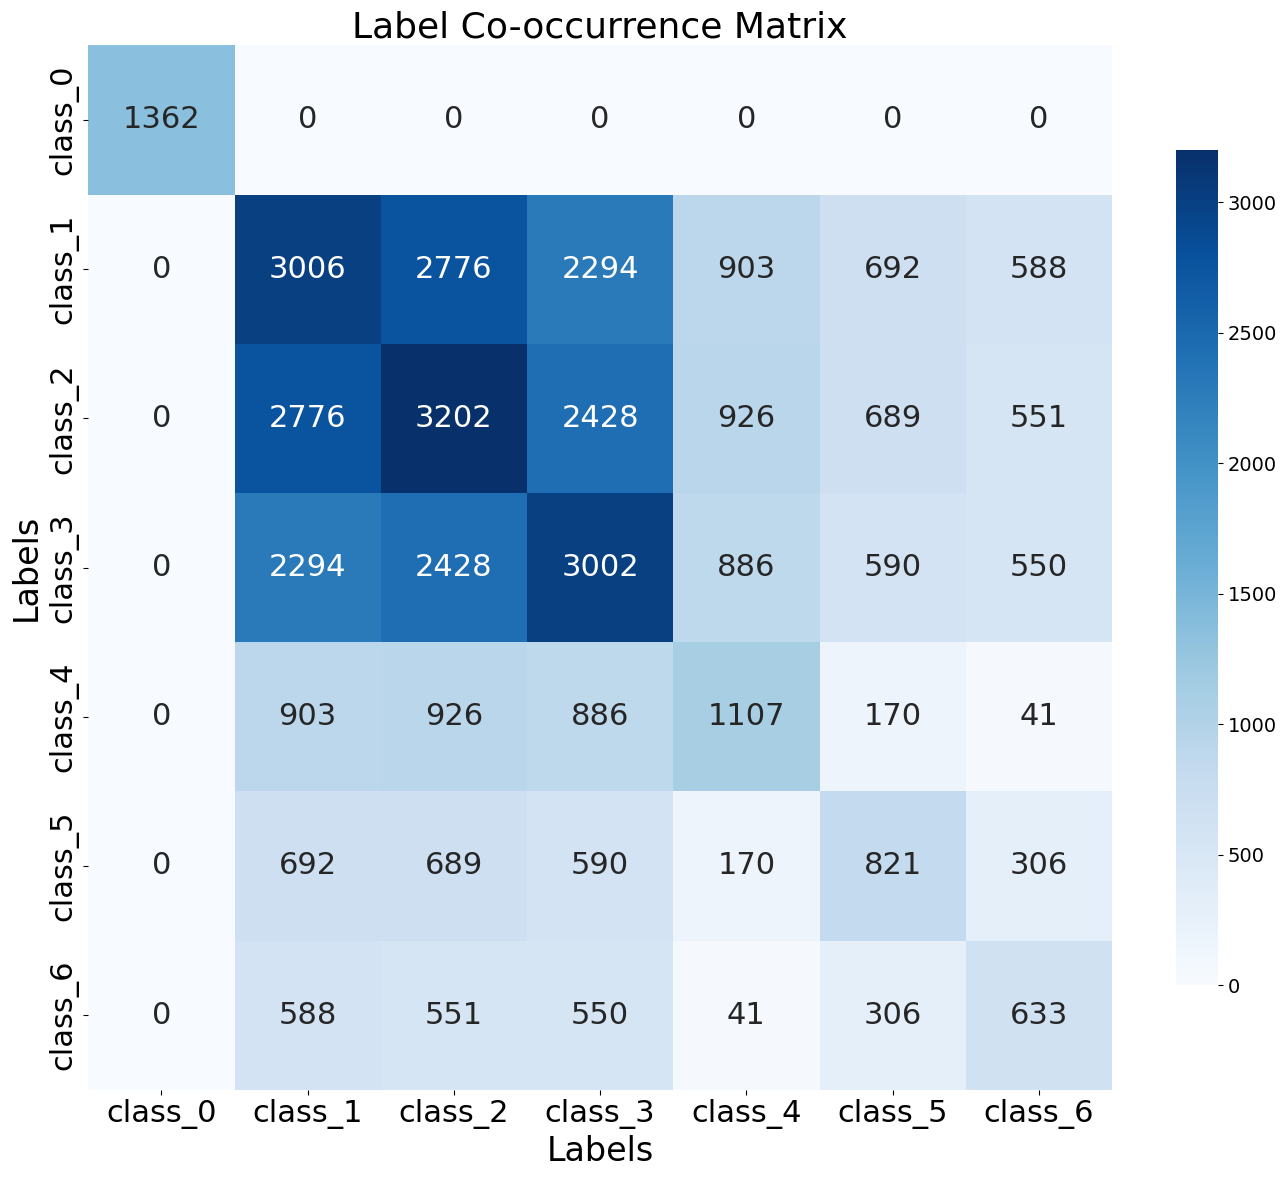


Label Statistics:
class_0: 1362.0 samples (24.55%)
class_1: 3006.0 samples (54.19%)
class_2: 3202.0 samples (57.72%)
class_3: 3002.0 samples (54.12%)
class_4: 1107.0 samples (19.96%)
class_5: 821.0 samples (14.80%)
class_6: 633.0 samples (11.41%)

Common Label Combinations:
['class_0']: 1362 samples (24.55%)
['class_1', 'class_2', 'class_3']: 828 samples (14.93%)
['class_1', 'class_2', 'class_3', 'class_4']: 587 samples (10.58%)
['class_3']: 428 samples (7.72%)
['class_1', 'class_2']: 352 samples (6.35%)


In [27]:
class_names = ['class_'+str(i) for i in range(7)]  # 실제 클래스 이름으로 대체
analyze_label_distribution( trainloader, valloader, testloader, class_names)

In [39]:
df['label']

0           [0, 10]
1        [3, 9, 10]
2           [0, 10]
3              [10]
4               [0]
           ...     
6471        [0,  8]
6472        [0,  8]
6473    [0,  8, 10]
6474    [0,  8, 10]
6475    [0,  8, 10]
Name: label, Length: 6476, dtype: object

원본 데이터 수: 6476
필터링 후 데이터 수: 6476
Shape of y_true_binary: (6476, 7)
Sum of each class: [2765 1821 2131 2186  469   57   18]
Classes: [0 1 2 3 4 5 6]


/root/anaconda3/envs/nmc/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [10, 110, 12, 140, 310, 7, 8, 810, 9] will be ignored
  warnings.warn(


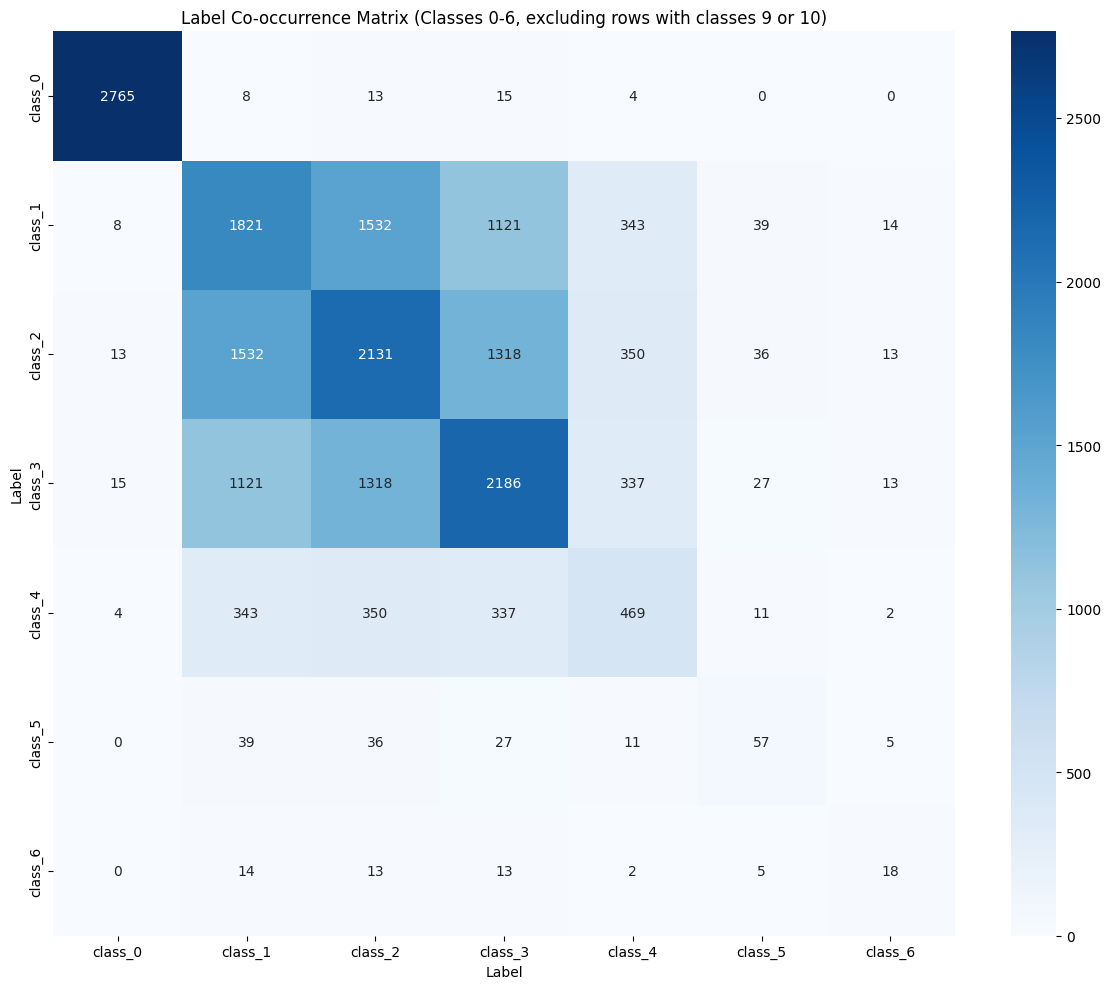

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Read the labels
df = pd.read_csv('/datas/fundus_dataset/NMC/final_label.csv')

# Convert string labels to list and check for classes 9 or 10
def convert_label(x):
    has_invalid_class = False
    result_list = []
    
    if isinstance(x, str):
        # Remove brackets and split by comma
        items = str(x).strip('[]').split(',')
        # Check each item
        for item in items:
            if item.strip():
                val = int(item.strip())
                # if val in [9, 10]:  # 클래스 9나 10이 포함되어 있으면 플래그 설정
                #     has_invalid_class = True
                # elif val < 7:  # 유효한 클래스(0-6)만 추가
                result_list.append(val)
    elif isinstance(x, (int, float)):
        val = int(x)
        # if val in [7, 8, 9, 10]:
        #     has_invalid_class = True
        # elif val < 7:
        result_list.append(val)
    
    # 클래스 9나 10이 포함된 경우 None 반환 (이후에 필터링하기 위함)
    return None if has_invalid_class else result_list

# 라벨 변환 적용
df['label'] = df['label'].apply(convert_label)

# 클래스 9나 10이 포함된 행(None으로 변환된 행) 제거
df_filtered = df.dropna(subset=['label'])
print(f"원본 데이터 수: {len(df)}")
print(f"필터링 후 데이터 수: {len(df_filtered)}")

# 클래스 0-6만 사용
valid_classes = list(range(7))  # [0, 1, 2, 3, 4, 5, 6]
mlb = MultiLabelBinarizer(classes=valid_classes)
y_true_binary = mlb.fit_transform(df_filtered['label'])

# 변환 결과 확인
print(f"Shape of y_true_binary: {y_true_binary.shape}")
print(f"Sum of each class: {y_true_binary.sum(axis=0)}")
print(f"Classes: {mlb.classes_}")

# Calculate co-occurrence matrix
true_cooccurrence = np.zeros((len(mlb.classes_), len(mlb.classes_)))
for row in y_true_binary:
    # Find indices where labels are present (1)
    present_labels = np.where(row == 1)[0]
    # Update co-occurrence for all pairs of present labels
    for i in present_labels:
        for j in present_labels:
            true_cooccurrence[i][j] += 1

# 시각화를 위한 라벨 이름 생성
label_names = ['class_'+str(i) for i in mlb.classes_]

# Create heatmap for true labels co-occurrence
plt.figure(figsize=(12,10))
sns.heatmap(true_cooccurrence, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Label')
plt.ylabel('Label')
plt.title('Label Co-occurrence Matrix (Classes 0-6, excluding rows with classes 9 or 10)')
plt.tight_layout()
plt.show()